In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import resource
import sys
from IPython.display import display

from genquad.functionfamiliy import Interval
from genquad.testproblems import example_problem, gen_poly_and_sing
from genquad.discretize import adaptive_discretization
from genquad.compress import compress_sequence_of_functions, construct_Chevyshev_quadratures, visualise_diagonal_dropoff
from genquad.optimize import QuadOptimizer

resource.setrlimit(resource.RLIMIT_STACK, [0x10000000, resource.RLIM_INFINITY])
sys.setrecursionlimit(0x100000)

In [2]:
eps_disc = 1e-10
eps_comp = 1e2*eps_disc
eps_quad = 1e-2
I = Interval(1e-6,1)
seed = 0

In [3]:
rng_gen = np.random.default_rng(seed)
F = example_problem(I, number_of_functions = 100, expr_gen=gen_poly_and_sing)
ex_f, ex_f_expr = F.generate_example_function()

Example function from function space


9.49476637512931*x**10 - 4.56581328989052*x**9 - 6.74800418249427*x**8 + 1.53358035094406*x**7 + 5.93011162062097*x**6 - 6.76667717657086*x**5 - 4.87659075690458*x**4 + 1.83944445493968*x**3 + 10.3557082255434*x**2 - 3.92322062633946*x + 3.53093077046836 - 0.128689804881883/x

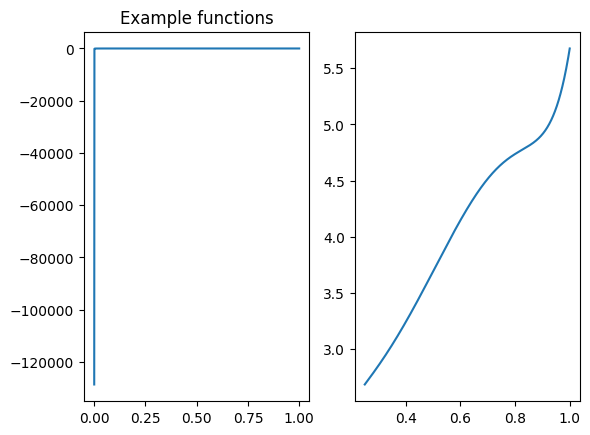

In [4]:
print("Example function from function space")
display(ex_f_expr)
xx = np.linspace(I.a,I.b,1000)
functions_to_plot = 5
plt.subplot(1, 2, 1)
plt.title("Example functions")
plt.plot(xx,ex_f(xx))
plt.subplot(1, 2, 2);
xx2 = np.linspace((I.a + I.b)/4,I.b,1000)
plt.plot(xx2,ex_f(xx2));

Discretization and compression

In [5]:
k = 30
x_disc, w_disc, endpoints, intervals = adaptive_discretization(F, eps_disc, k, verbose=False)
U_disc, A, rank, u_list = compress_sequence_of_functions(F, x_disc, w_disc, eps_comp, k, intervals)

Functions before compression: 100
Functions after compression: 12


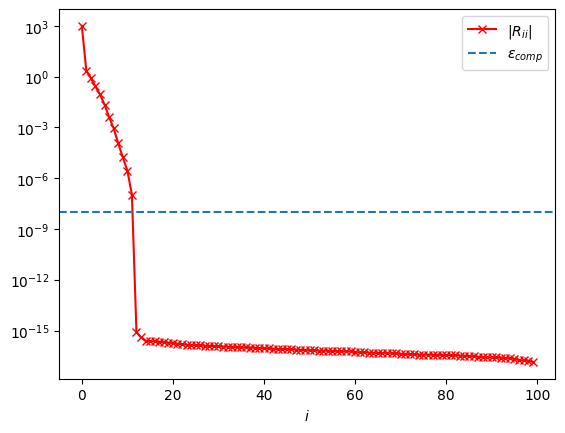

In [6]:
print("Functions before compression:", len(F.functions))
print("Functions after compression:", len(u_list))
visualise_diagonal_dropoff(A, eps_comp)

Chebyshev Rule

In [7]:
x_cheb, w_cheb, idx_cheb = construct_Chevyshev_quadratures(x_disc,w_disc,U_disc)

In [8]:
print("Number of points in original discretization:", len(x_disc))
print("Number of points in Chebyshev rule:", len(x_cheb))
print("Absolute integral error for chebyshev:", abs(F.target_integral(ex_f_expr)-ex_f(x_cheb)@w_cheb))

Number of points in original discretization: 1140
Number of points in Chebyshev rule: 12
Absolute integral error for chebyshev: 2.22044604925031e-15


Naive nonlinear optimization

In [9]:
r = U_disc.T@w_disc

In [10]:
opt = QuadOptimizer(u_list,r)
opt.set_parameters(0.8,1000,1e-9)
x_naive, w_naive = opt.naive_optimization(6, F.I)

In [11]:
print("Naive quadrature length: ", len(x_naive))
print("Naive error:", abs(F.target_integral(ex_f_expr)-ex_f(x_naive)@w_naive))

Naive quadrature length:  6
Naive error: 0.617141984239625


In [12]:
opt = QuadOptimizer(u_list,r)
opt.set_parameters(0.8,100,1e-6)
r = U_disc.T@w_disc
x,w = opt.point_reduction(x_cheb, w_cheb, eps_quad)

[0.026084008958225186, 0.029337860311354505, 0.045601242237238056, 0.048305428384518366, 0.07225719667958234, 0.07369788555094636, 0.07533863517284405, 0.08869229702583212, 0.09881878133292668, 0.1075457115529845, 0.14512763248825922, 0.19356310188598438]
[0.0273780074643606, 0.04560602602604136, 0.04828095389477645, 0.0759805873327483, 0.07674732862499041, 0.08816920079248919, 0.10914009468628606, 0.1454101315429172, 0.19455269243416565, 0.2926182118174045, 25.10389654035262]
[0.047610464543207394, 0.06167567611556475, 0.07662164451604912, 0.09099554984751868, 0.11201387274174485, 0.14493812421793328, 0.20013566618351275, 0.31822161487954115, 2.7063688231212146, 33.31143923619711]
[0.07709562834751377, 0.08014616351265054, 0.09714422342626769, 0.11456334502135566, 0.18635781271579527, 0.3236128328693929, 0.4053245248501933, 2.6376554988920295, 33.34268351788107]
[0.07894500478525741, 0.10432695198628475, 0.19407603917207616, 0.28002981659706455, 0.42892734316760506, 2.887600341622615,

In [13]:
print("Quadrature length: ", len(x))
print("Absolute error:", abs(F.target_integral(ex_f_expr)-ex_f(x)@w))

Quadrature length:  6
Absolute error: 2.09312406518336e-7


Comparison with Gauss-Legendre

Gauss-Legendre [0.034 0.169 0.381 0.619 0.831 0.966]
New quadrature [0.003 0.101 0.307 0.563 0.803 0.96 ]


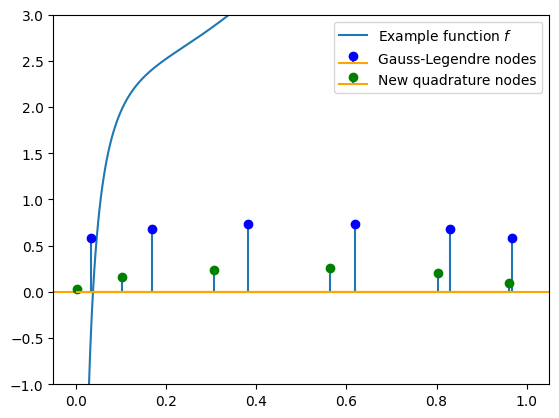

In [14]:
fig, ax = plt.subplots()
ax.plot(xx, ex_f(xx),label=r"Example function $f$")
ax.set_ylim(-1,3)
x_gl,w_gl = I.translate(np.polynomial.legendre.leggauss(len(x)))
ax.axhline(y=0,c="orange")
ax.stem(x_gl, w_gl, markerfmt = 'bo', basefmt="orange", label=r"Gauss-Legendre nodes")
ax.stem(x, w, markerfmt = 'go', basefmt="orange", label=r"New quadrature nodes")
ax.legend()
print("Gauss-Legendre",np.around(x_gl,3))
print("New quadrature",np.around(sorted(x),3))